## Testing Astroquery
A Notebook which will test getting data from MAST. This might be the same as the HLA data, but I'm not sure. For now, I'm going to just see if I can make this work for the galaxies in my paper.

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

In [192]:
df = pd.read_csv('C:/Users/oryan/Documents/zoobot_new/manifests/gz-hubble-local-manifest.csv',index_col=0)

In [193]:
test_row = df.iloc[0]
ra = test_row['RA']
dec = test_row['Dec']
#mission = test_row['imaging']

In [194]:
test_row

zooniverse_id                                            AHZ10004js
RA                                                          215.001
Dec                                                         52.9554
imaging                                                       AEGIS
interacting                                                       1
local_location    C:/Users/oryan/Documents/zoobot/hubble-dataset...
Name: 5895, dtype: object

In [195]:
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')

In [196]:
obs_table = Observations.query_region(coord,radius=0.02 * u.deg)

In [197]:
obs_table.colnames

['intentType',
 'obs_collection',
 'provenance_name',
 'instrument_name',
 'project',
 'filters',
 'wavelength_region',
 'target_name',
 'target_classification',
 'obs_id',
 's_ra',
 's_dec',
 'dataproduct_type',
 'proposal_pi',
 'calib_level',
 't_min',
 't_max',
 't_exptime',
 'em_min',
 'em_max',
 'obs_title',
 't_obs_release',
 'proposal_id',
 'proposal_type',
 'sequence_number',
 's_region',
 'jpegURL',
 'dataURL',
 'dataRights',
 'mtFlag',
 'srcDen',
 'obsid',
 'distance']

In [198]:
obs_table.to_pandas().instrument_name.value_counts()

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: TableReplaceWarning: converted column 'sequence_number' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


IRAC            286
ACS/WFC         172
WFC3/IR         149
NIRCAM/IMAGE    102
NIRCAM/GRISM     82
NIRSPEC/MSA      54
GALEX            34
MIRI/IMAGE       33
ACS              28
WFC3/UVIS        27
NIRISS/MSA       19
MIPS             15
UVOT             12
WFC3             10
WFPC2/WFC        10
NICMOS/NIC3       6
GPC1              5
MegaCam           5
Photometer        4
WIRCam            3
Name: instrument_name, dtype: int64

In [199]:
obs_table.to_pandas().filters.value_counts()['r']

1

In [216]:
data_df = obs_table.to_pandas().query('obs_collection == "HLA"').query('filters == "F606W" or filters == "F814W" or filters == "F435W"')[:2]

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: TableReplaceWarning: converted column 'sequence_number' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [221]:
data_df['dataURL'].iloc[0]

'https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_10134_15_acs_wfc_f606w_drz.fits'

In [163]:
data_product = Table.from_pandas(
    obs_table
    .to_pandas()
    .sort_values('t_exptime', ascending=False)
    .query('instrument_name == "ACS/WFC"')
    .query('intentType == "science"')
    .query('dataproduct_type == "image"')
    .query('obs_collection == "HST" or obs_collection == "HLA"')
)

In [164]:
data_product['filters']

CLEAR1L;F435W
detection
detection
F435W
F435W
CLEAR1L;F435W
detection
F435W
F435W
CLEAR1L;F435W
CLEAR1L;F435W


In [165]:
obs_id = data_product[0]['obs_id']

In [166]:
obs_id

'jdxf33010'

In [167]:
filter_download = data_product['filters'][0]

In [168]:
single_obs = Observations.query_criteria(obs_id=obs_id, filters=filter_download)

In [169]:
single_obs

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str3,str9,str3,float64,float64,float64,float64,float64,str7,str13,float64,float64,str27,str108,float64,str7,str14,str5,str2,str3,int64,str6,str451,str34,str35,str6,bool,float64,str7,str8,str9
image,3,HST,jdxf33010,ANY,215.0288497252,52.93973498428,58783.3446659375,58783.50443425926,7292.0,Optical,CLEAR1L;F435W,200.0,1100.0,UNIDENTIFIED;PARALLEL FIELD,Ultraviolet Imaging of the Cosmic Assembly Near-infrared Deep Extragalactic Legacy Survey Fields (UVCANDELS),58784.2780902,ACS/WFC,"Teplitz, Harry",15647,GO,HST,--,CALACS,POLYGON -144.92468535 52.90486941 -144.92468161965718 52.904944417953928 -144.92467376000002 52.90494395 -144.92325027000004 52.93354816 -144.92331223609051 52.933551847690744 -144.92331222999996 52.93355197 -145.01703122000004 52.93909168 -145.01703479259243 52.9390166792851 -145.01704264 52.93901714 -145.01840433 52.91041183 -145.01834244594957 52.910408195137656 -145.01834244999998 52.91040811 -144.92468535 52.90486941 -144.92468535 52.90486941,mast:HST/product/jdxf33010_drc.jpg,mast:HST/product/jdxf33010_drz.fits,PUBLIC,False,nan,science,26248587,137492761


In [170]:
data_products = Observations.get_product_list(single_obs)
len(data_products)

110

In [171]:
data_products_download = Observations.filter_products(
    data_products,
    productType=['SCIENCE'],
    extension='fits'
)

In [172]:
products_download = join(data_product,data_products_download,keys='obs_id')

In [173]:
len(products_download)

4

In [174]:
products_download.rename_columns(['obs_collection_1'],['obs_collection'])

In [175]:
products_download.colnames

['intentType',
 'obs_collection',
 'provenance_name',
 'instrument_name',
 'project_1',
 'filters',
 'wavelength_region',
 'target_name',
 'target_classification',
 'obs_id',
 's_ra',
 's_dec',
 'dataproduct_type_1',
 'proposal_pi',
 'calib_level_1',
 't_min',
 't_max',
 't_exptime',
 'em_min',
 'em_max',
 'obs_title',
 't_obs_release',
 'proposal_id_1',
 'proposal_type',
 'sequence_number',
 's_region',
 'jpegURL',
 'dataURL',
 'dataRights_1',
 'mtFlag',
 'srcDen',
 'obsid',
 'distance',
 'obsID',
 'obs_collection_2',
 'dataproduct_type_2',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project_2',
 'prvversion',
 'proposal_id_2',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights_2',
 'calib_level_2']

In [184]:
products_download

intentType,obs_collection,provenance_name,instrument_name,project_1,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type_1,proposal_pi,calib_level_1,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id_1,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights_1,mtFlag,srcDen,obsid,distance,obsID,obs_collection_2,dataproduct_type_2,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project_2,prvversion,proposal_id_2,productFilename,size,parent_obsid,dataRights_2,calib_level_2
str7,str3,str6,str7,str3,str13,str16,str9,str32,str35,float64,float64,str5,str18,int64,float64,float64,float64,float64,float64,str115,float64,str5,str3,float64,str2286,str79,str88,str6,object,float64,str8,float64,str8,str3,str5,str64,str1,str67,str9,str28,str11,str1,str6,str20,str5,str50,int64,str8,str6,int64
science,HST,HAP,ACS/WFC,HAP,F435W,Optical,ANY,--,hst_15647_33_acs_wfc_f435w_jdxf33,215.0288122875,52.93968072741,image,"Teplitz, Harry",3,58783.34466594,58783.50444658,7292.0,370.0,479.99999999999994,--,58784.2780902,15647,HAP,--,POLYGON -144.92447549999989 52.933808200000009 -144.92416984999997 52.961016410000063 -145.01555356 52.967503020000152 -145.0155546069729 52.967485935944985 -145.01559966999977 52.967489110000066 -145.01732228999973 52.939766220000045 -145.01725255473121 52.939761759045737 -145.01725313000009 52.939752360000192 -144.98573928647542 52.937741588666434 -144.92454464999992 52.933794329999884 -144.92454442901976 52.933812643634582 -144.92447549999989 52.933808200000009 -144.92447549999989 52.933808200000009 POLYGON -144.92467376000002 52.90494395 -144.92325027000004 52.93354816 -144.92331223609051 52.933551847690737 -144.92331222999996 52.93355197 -144.92448213321137 52.93362158593888 -144.92455064778451 52.933625662585165 -145.01703122000004 52.93909168 -145.01703838324926 52.93894129907693 -145.01734446000026 52.938960659999985 -145.01734555446563 52.9389439045036 -145.01739054000021 52.938946750000014 -145.01929394000013 52.910168210000172 -145.01922417148697 52.91016444479672 -145.0192248299997 52.910154350000063 -144.95318354596421 52.90658145861719 -144.92471116000002 52.90488974 -144.92470836171631 52.904946010137927 -144.92467376000002 52.90494395 -144.92467376000002 52.90494395,mast:HST/product/hst_15647_33_acs_wfc_f435w_jdxf33_drc.jpg,mast:HST/product/hst_15647_33_acs_wfc_f435w_jdxf33_drc.fits,PUBLIC,False,--,26308196,0.0,26308196,HST,image,HAP fits science image,D,mast:HST/product/hst_15647_33_acs_wfc_f435w_jdxf33_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,15647,hst_15647_33_acs_wfc_f435w_jdxf33_drc.fits,244108800,26248587,PUBLIC,3
science,HST,HAP,ACS/WFC,HAP,detection,--,ANY,--,hst_15647_33_acs_wfc_total_jdxf33,215.0288122875,52.93968072741,image,"Teplitz, Harry",3,58783.34466594,58783.50444658,7292.0,--,--,--,58784.2780902,15647,HAP,--,POLYGON -144.92447549999989 52.933808200000009 -144.92416984999997 52.961016410000063 -145.01555356 52.967503020000152 -145.0155546069729 52.967485935944985 -145.01559966999977 52.967489110000066 -145.01732228999973 52.939766220000045 -145.01725255473121 52.939761759045737 -145.01725313000009 52.939752360000192 -144.98573928647542 52.937741588666434 -144.92454464999992 52.933794329999884 -144.92454442901976 52.933812643634582 -144.92447549999989 52.933808200000009 -144.92447549999989 52.933808200000009 POLYGON -144.92467376000002 52.90494395 -144.92325027000004 52.93354816 -144.92331223609051 52.933551847690737 -144.92331222999996 52.93355197 -144.92448213321137 52.93362158593888 -144.92455064778451 52.933625662585165 -145.01703122000004 52.93909168 -145.01703838324926 52.93894129907693 -145.01734446000026 52.938960659999985 -145.01734555446563 52.9389439045036 -145.01739054000021 52.938946750000014 -145.01929394000013 52.910168210000172 -145.01922417148697 52.91016444479672 -145.0192248299997 52.910154350000063 -144.95318354596421 52.90658145861719 -1

In [177]:
manifest = Observations.download_products(
    products_download,
    productType='SCIENCE',
    obs_collection=['HST','HLA'],
    download_dir = 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/',
    extension=['fits']
)

In [178]:
manifest['Local Path']

C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\HST\hst_15647_33_acs_wfc_f435w_jdxf33\hst_15647_33_acs_wfc_f435w_jdxf33_drc.fits
C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\HST\hst_15647_33_acs_wfc_total_jdxf33\hst_15647_33_acs_wfc_total_jdxf33_drc.fits
C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\HST\jdxf33010\jdxf33010_drc.fits
C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\HST\jdxf33010\jdxf33010_drz.fits


### Reload FITS File

In [179]:
files = manifest['Local Path']

In [180]:
hdus = [fits.open(file) for file in files]

### Create the Cutout png

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


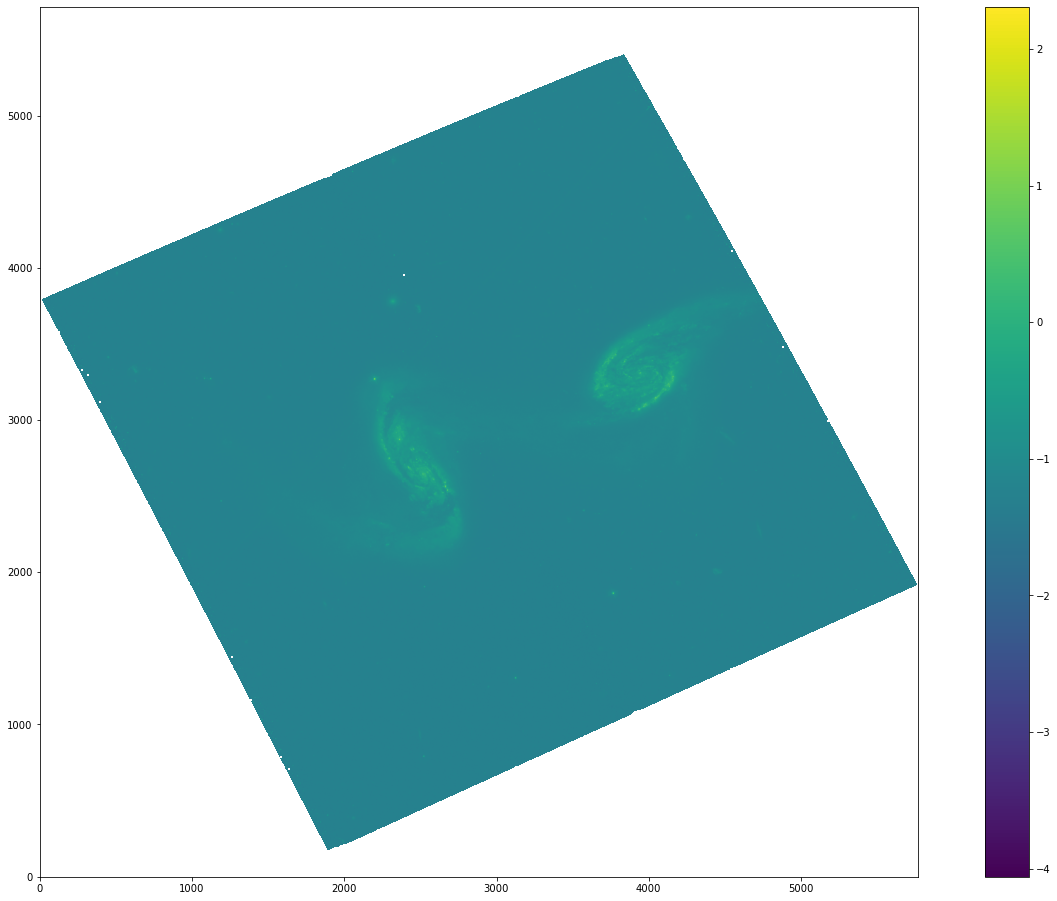

In [126]:
plt.figure(figsize = (24,16))
plt.imshow(np.log10(counts), origin='lower')
plt.colorbar()

### Normalizing the Image

In [123]:
norm = ImageNormalize(cutout,interval=ZScaleInterval(nsamples=5000,contrast=0.02),stretch=AsinhStretch())

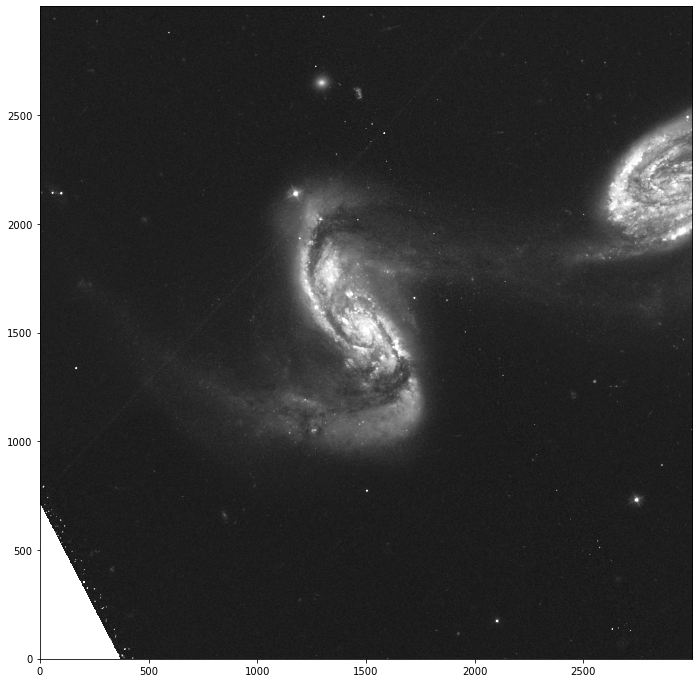

In [124]:
plt.figure(figsize=(24,12))
plt.imshow(cutout,cmap='Greys_r',origin='lower',norm=norm)

In [136]:
manifest['Local Path'][0]

'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\\HST\\hst_15647_33_acs_wfc_f435w_jdxf33\\hst_15647_33_acs_wfc_f435w_jdxf33_drc.fits'

In [137]:
os.path.dirname(manifest['Local Path'][0])

'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/mastDownload\\HST\\hst_15647_33_acs_wfc_f435w_jdxf33'

In [138]:
if os.path.exists(os.path.dirname(manifest['Local Path'][0])):
    os.remove(manifest['Local Path'][0].replace('\\','/'))
    folder = os.path.dirname(manifest['Local Path'][0])
    os.rmdir(folder)
else:
    pass

In [76]:
from PIL import Image
import numpy as np

In [77]:
C:\Users\oryan\Documents\zoobot_new\cutouts

SyntaxError: unexpected character after line continuation character (<ipython-input-77-d902dba6675d>, line 1)

In [90]:
np.asarray(Image.open('C:/Users/oryan/Documents/zoobot_new/cutouts/Arp290_thumbnail.png')).shape

(300, 300)